# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import import_ipynb
import pandas as pd
import os

try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from SpatialTemporal_Correlation_and_Convolution import STconvolve
%matplotlib inline

importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb


In [2]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

In [3]:
def ParaTrans(ASparadict, mag):     # because of overfitting, I assume alpha = mag*beta
    for k in ASparadict.keys():
        globals()[k] = ASparadict[k]
    global beta, alpha, g, l, Amp 
    
    beta = epsilon*2/(1+mag)
    alpha = epsilon*2*mag/(1+mag)
    g = omegastar**2 + (alpha-beta)**2 /4
    l = ((2*omegastar*np.tan(deltastar)*(-beta+gamma)+(alpha-beta)*(beta-gamma)+2*g)/
                (g*(-alpha-beta+2*gamma-2*omegastar*np.tan(deltastar))))
    Amp = Dmp*(g+alpha*beta-alpha*gamma-beta*gamma+gamma**2)/(-beta+gamma+g*l)
    DiffParadict = {'alpha':[], 'beta':[], 'gamma':[], 'g':[], 'l':[], 'tau_y':[], 'Amp':[], 'error':[]}
    for k in DiffParadict.keys():
        DiffParadict[k] = globals()[k]
    return DiffParadict

In [4]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))/s/np.sqrt(np.pi*2)

def FB_FF_1l_1D(stimulus, sigma_dict, para_dict, dx, dt, HeadWeight=50):
    
    klen = min(max(sigma_dict.values())*3, int(stimulus.shape[1]/2/dx))
    xx = np.arange(-klen,klen+dx,dx)
    KC = Gaussian_filter_1d(xx,sigma_dict['C'])
    KH = Gaussian_filter_1d(xx,sigma_dict['H'])
    KB = Gaussian_filter_1d(xx,sigma_dict['B'])
    
    T  = np.arange(0,int(para_dict['tau_y']/dt*15))*dt
    Ky = T/para_dict['tau_y'] /para_dict['tau_y'] *np.exp(-T/para_dict['tau_y'])
    sstm = np.array([np.convolve(stimulus[:,j], Ky, 'full')[:stimulus.shape[0]]*dt for j in range(stimulus.shape[1])]).T

    zts = np.zeros_like(stimulus)#Cone
    yts = np.zeros_like(stimulus)#horizontal
    wts = np.zeros_like(stimulus)#Bipolar
    
    IHeadto = stimulus.shape[0]
    HeadTaxis = np.arange(IHeadto)*dt
    LongHeadTaxis = np.arange(0, IHeadto*dt-dt+dt/HeadWeight/2, dt/HeadWeight)
    HeadStimulus = interpolate.interp1d(HeadTaxis, sstm[:IHeadto,:], axis = 0)(LongHeadTaxis)
    Hzts = np.zeros_like(HeadStimulus)#horizontal
    Hyts = np.zeros_like(HeadStimulus)#horizontal
    Hwts = np.zeros_like(HeadStimulus)#horizontal
    for i in np.arange(np.shape(HeadStimulus)[0]-1):
        s = HeadStimulus[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry2z = np.convolve(Hyts[i,:],KH,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        dyj =(-para_dict['alpha']*Hyts[i,:]+(rs-Hzts[i,:]))*dt/HeadWeight
        dzj =(-para_dict['beta']*Hzts[i,:]+para_dict['g']*ry2z)*dt/HeadWeight
        ry2w = np.convolve(Hyts[i,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        dwj =(-para_dict['gamma']*Hwts[i,:]+ry2w-para_dict['l']*Hzts[i,:])*dt/HeadWeight
        Hyts[i+1,:] = (Hyts[i,:]+dyj)
        Hzts[i+1,:] = (Hzts[i,:]+dzj)
        Hwts[i+1,:] = (Hwts[i,:]+dwj)
    yts[:IHeadto,:] = Hyts[::HeadWeight,:]
    zts[:IHeadto,:] = Hzts[::HeadWeight,:]
    wts[:IHeadto,:] = Hwts[::HeadWeight,:]

        
    return para_dict['Amp']*wts, zts, yts

In [5]:
def NGD2L_TK_AS(T, epsilon, gamma, omegastar, deltastar, tau_y, Dmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kw = -Dmp*( 1/np.cos(deltastar)*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar) -np.exp(-gamma*T) )
    w = np.convolve(x, Kw, 'full')[:len(T):50]*dt
    return w/(dt)


def NGD2L_TK(T, alpha, beta, gamma, g, l, tau_y, Amp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    y=np.zeros_like(x)
    z=np.zeros_like(x)
    w=np.zeros_like(x)
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j] + x[j]-z[j] )
        dz=dt*(-beta* z[j] + g*y[j] )
        dw=dt*(-gamma*w[j] + y[j]-l*z[j] )
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
        w[j+1]=w[j]+dw

    return -Amp*w[::50]/(dt)


# Setting parameters from fitting real TK

In [6]:
loadfiles = np.load('D:\\GoogleDrive\\retina\\Chou\'s data\\20210506\\Analyzed_data\\fitNGD2LASpara.npz', allow_pickle=True)
for k in loadfiles.files:
    vars()[k] = loadfiles[k][()]
cn = 21
pd.DataFrame(para_dict).loc[cn-1]

epsilon       9.182595
gamma        40.022856
omegastar    27.041691
deltastar    -0.553049
tau_y         0.024989
Dmp           4.527099
error         0.416390
Name: 20, dtype: float64

In [7]:
FBFF_sigma_dict = dict()
FBFF_sigma_dict['H'] = 1
FBFF_sigma_dict['C'] = FBFF_sigma_dict['H']*0.3 # RF size of cone cell
FBFF_sigma_dict['B'] = FBFF_sigma_dict['H']*0.3

dx = FBFF_sigma_dict['H']/40.
xlen = 20*FBFF_sigma_dict['H'] #spatial extend of simulation
SKxaxis = np.arange(-int(xlen/dx/2),int(xlen/dx/2)+1)*dx


dt=1/60 #large dt will cause  overflow
nstep = int(1./dt)
TKtaxis = np.arange(nstep)*dt

FBFF_para_dict  = pd.DataFrame(ParaTrans(para_dict, 1)).loc[cn-1]

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


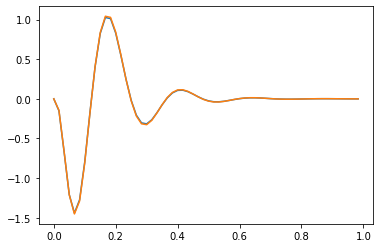

In [8]:
plt.plot(TKtaxis, NGD2L_TK_AS(TKtaxis, *pd.DataFrame(para_dict).loc[cn-1][:-1]))
plt.plot(TKtaxis, NGD2L_TK(TKtaxis, *FBFF_para_dict[:-1]))

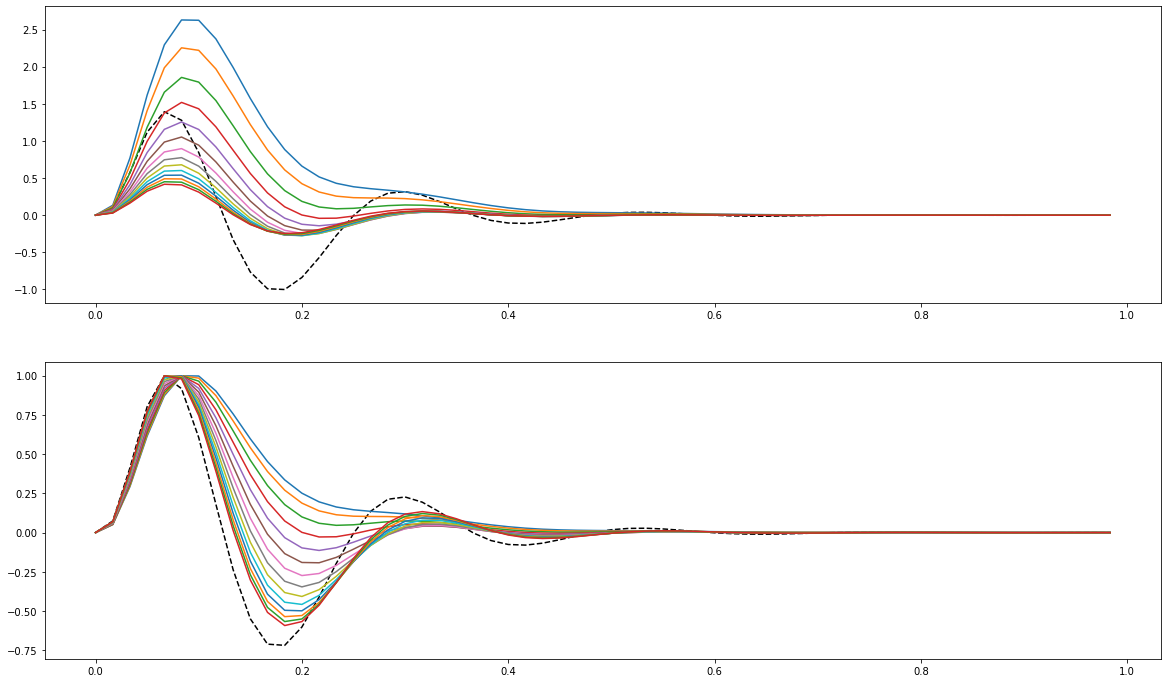

In [9]:
fig, ax = plt.subplots(2,1)
TDelta_input = np.zeros([len(TKtaxis), int(xlen/dx)+1])
TDelta_input[0,:] = 1
TDelta_output_w, zts, TDelta_output_y = FB_FF_1l_1D(TDelta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)
delTK = TDelta_output_w[:len(TKtaxis),int(xlen/dx/2)]/dt #normalized by height of delta function
ax[0].plot(TKtaxis, delTK, 'k--')
ax[1].plot(TKtaxis, delTK/max(delTK), 'k--')

for i in np.arange(0.1,1.5,0.1):
    FBFF_sigma_dict['C'] = FBFF_sigma_dict['H']*i # RF size of cone cell
    Delta_input = np.zeros([nstep, int(xlen/dx)+1])
    Delta_input[0, int(xlen/dx/2)] = 1
    Delta_output_w, zts, Delta_output_y = FB_FF_1l_1D(Delta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)

    delSTK = Delta_output_w/dt/dx

    ax[0].plot(TKtaxis, delSTK[:, int(xlen/dx/2)])
    ax[1].plot(TKtaxis, delSTK[:, int(xlen/dx/2)]/np.max(delSTK))
fig.set_size_inches(20,12)

In [10]:
FBFF_sigma_dict['C'] = FBFF_sigma_dict['H']*0.8 # RF size of cone cell
Delta_input = np.zeros([nstep, int(xlen/dx)+1])
Delta_input[0, int(xlen/dx/2)] = 1
Delta_output_w, zts, Delta_output_y = FB_FF_1l_1D(Delta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)
delSTK = Delta_output_w/dt/dx

U,sigma,VT=np.linalg.svd(delSTK)
SVDSTK = U[:,0][:, np.newaxis]*VT[0,:][np.newaxis, :]

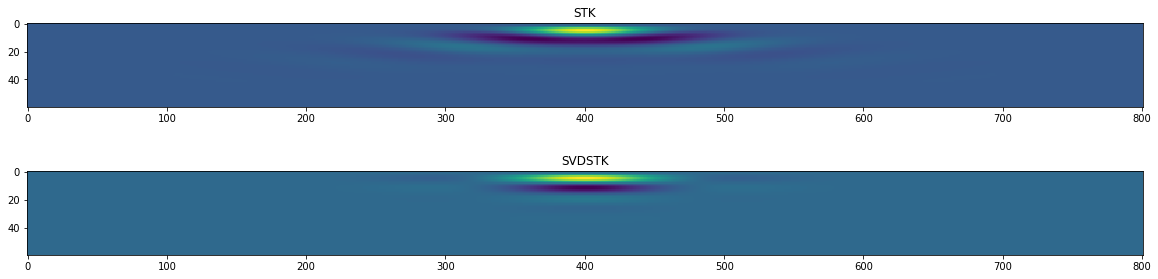

In [11]:
fig, ax = plt.subplots(2,1)
ax[0].imshow(delSTK)
ax[0].set_title('STK')
ax[1].imshow(SVDSTK)
ax[1].set_title('SVDSTK')
plt.gcf().set_size_inches(20, 5)

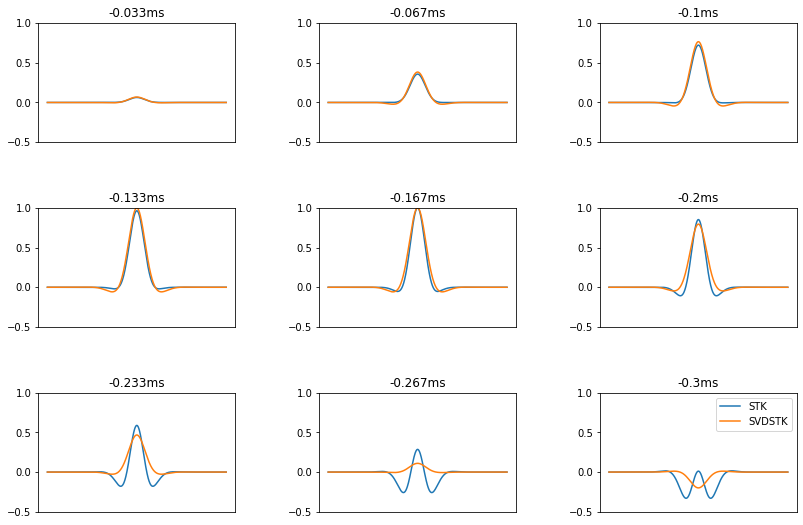

In [12]:
fig, ax = plt.subplots(3,3)
for i in range(9):
    delSTK[i+1,:]
    ax.flatten()[i].plot(delSTK[i+1,:]/np.max(delSTK), label='STK')
    ax.flatten()[i].plot(SVDSTK[i+1,:]/np.max(SVDSTK), label='SVDSTK')
    
    ax.flatten()[i].set_title(str(-1*np.round((i+1)/30, 3))+'ms')
    ax.flatten()[i].set_ylim([-0.5, 1])
    ax.flatten()[i].axes.xaxis.set_visible(False)
ax.flatten()[-1].legend(loc='best')
    
fig.tight_layout()
fig.set_size_inches(12,8)